In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import sys

In [3]:
from astropy.table import Table
from astropy.io import fits
import astropy.cosmology
from astropy import units as u
from astropy.coordinates import SkyCoord

In [4]:
sys.path.insert(0, '/home/aew492/CFE_gradients')
from funcs.load_tools import ra_dec
from funcs.random_cat import generate_random_z

In [5]:
scratch = '/scratch/aew492'

### Load in data

In [6]:
quasar_fn = os.path.join(scratch, 'quasars/catalogs/gaia_G20.0.fits')

In [7]:
data_gaia = Table.read(quasar_fn, format='fits')
data_gaia

ra,dec,redshift_qsoc,l,b,source_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,redshift_qsoc_lower,redshift_qsoc_upper,zscore_qsoc,flags_qsoc,allwise_oid,w1mpro,w2mpro,g_rp,bp_g,bp_rp,g_w1,w1_w2,ebv,A_v,pm,redshift_spz,redshift_sdss
deg,deg,,deg,deg,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mag,mag,mag,,,,,,mag,mag,mag,mag,mag,mag,mag,,,mas / yr,,
float64,float64,float32,float64,float64,int64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,int64,int64,float64,float64,float32,float32,float32,float64,float64,float32,float32,float64,float64,float64
45.18857525358218,0.28242442525431893,1.7364681,176.85154355262011,-48.5708559360798,10892037246720,0.0016301676623204295,0.24633229,-0.09803741741546984,0.257395,-0.12058003593273806,0.22310686,18.78724,19.080688,18.240915,1.7260774,1.7468984,0.99530387,0,386619386,15.307,13.849,0.5463238,0.2934494,0.8397732,3.480239074707031,1.4580000000000002,0.111800425,0.3465813,0.15540553490476286,1.709,1.742328
45.189480360571665,0.3591947400894022,1.5130492,176.76912910053676,-48.51684235773577,15839839588736,-0.33315377915341504,0.34581935,-0.31608849256513893,0.36059502,0.31878129338774636,0.3265819,18.888464,19.17128,18.50937,1.4994327,1.52674,0.9990658,1,387078327,15.327,13.961,0.37909317,0.28281593,0.6619091,3.5614639739990235,1.3659999999999997,0.108534,0.3364554,0.44892476891575755,1.4967610836029053,1.502309
44.79936522932521,0.30355729158111383,2.8528538,176.4176643816323,-48.83530904204095,22780506725760,0.08502490683954063,0.30630586,0.16823689536016173,0.36143935,0.495425361757415,0.269473,19.218422,19.48634,18.8145,2.8428693,2.8628643,0.9999098,16,386745193,15.978,15.087,0.40392113,0.26791763,0.67183876,3.2404219360351565,0.891,0.08300958,0.25732967,0.5232111830158942,2.857,2.863
45.07952191471843,0.43963647300547504,2.4766529,176.56632979004348,-48.539725067910446,29102698617216,-0.9814862972527233,0.6914001,0.13363335786463076,0.5716444,-0.19487478827025342,0.4993483,19.837416,20.162195,19.387741,2.4496243,2.5038934,0.9393421,26,387560320,16.041,14.762,0.4496746,0.3247795,0.7744541,3.7964156951904293,1.279,0.09385592,0.29095334,0.23629231353887198,1.4314243793487549,1.52988
44.99106740350177,0.5817285409510972,0.8034798,176.31953253315504,-48.5037567938138,35115652874752,0.5372017504179936,0.2974623,0.2025059976484399,0.22700854,-0.010802838455522882,0.22789434,18.863981,19.050497,18.467363,0.7938221,0.8131895,0.999966,0,388409516,14.518,13.365,0.3966179,0.18651581,0.5831337,4.3459812469482415,1.1530000000000005,0.09363897,0.2902808,0.20279393581240557,0.801863,0.820964
45.46314576335495,0.5223631031122293,2.5434763,176.87877917393385,-48.206673850472285,45389214407424,0.42691239586060614,0.37638897,0.029875722687410865,0.3681689,0.8799332192684758,0.3576673,19.413044,19.660446,19.003618,2.529237,2.557773,0.9967636,16,388055279,16.384,15.452,0.40942574,0.24740219,0.6568279,3.029043975830078,0.9320000000000004,0.10517552,0.32604408,0.8804402473639416,2.515,--
45.61545491514258,0.6311201802539346,1.0362633,176.9198990209358,-48.021551935865055,47931835055360,-0.14579918000018588,0.30917633,0.15813672856887673,0.37432006,0.13010117641026012,0.3599602,19.366932,19.695724,18.919903,1.0209733,1.051669,0.940988,17,388703244,15.081,13.894,0.4470291,0.32879257,0.7758217,4.285931915283204,1.1869999999999994,0.087977216,0.27272937,0.2047768078318446,1.060027,1.044975
45.1740573490588,0.5437712901320596,1.1151339,176.55321656589015,-48.3993514340487,54528905041920,0.477410189720131,0.23120196,0.01704548904689053,0.21791558,-0.018600249184391956,0.21231827,18.86396,19.043858,18.563738,1.0972285,1.1331921,0.93471116,11,388183093,14.814,13.432,0.3002224,0.17989731,0.4801197,4.049960266113281,1.3819999999999997,0.09589272,0.29726744,0.025229307691039374,1.094694,1.112908


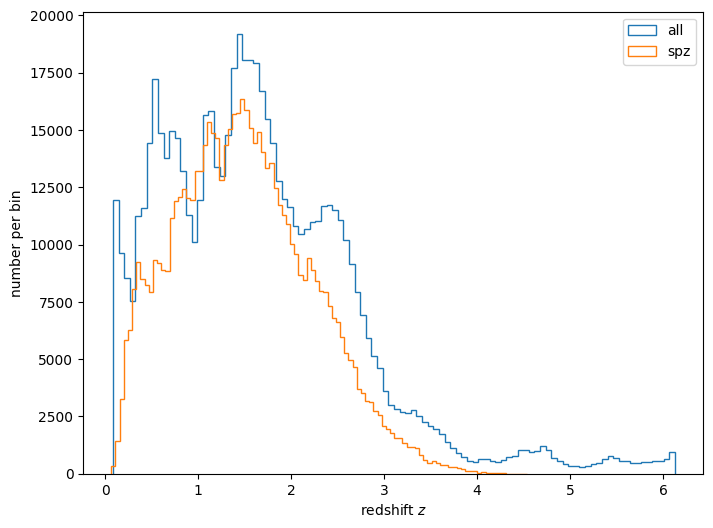

In [8]:
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(data_gaia['redshift_qsoc'], bins=100, histtype='step', label='all')
ax.hist(data_gaia['redshift_spz'], bins=100, histtype='step', label='spz')
ax.set_xlabel(r'redshift $z$')
ax.set_ylabel('number per bin')
ax.legend()

In [9]:
len(data_gaia)

648842

### Convert to Cartesian coordinates

I think the steps here are
1. $z\rightarrow$ radial distance $r$
2. (RA, Dec) $\rightarrow (\theta, \phi)$
3. $(r,\theta,\phi)\rightarrow (x,y,z)$

To convert redshift to a physical distance (#1), we must choose a cosmological model.
The other steps (#2-3) are simple coordinate transformations.

In [10]:
def z_to_r_comov(z):
    cosmo = astropy.cosmology.Planck15  # is this the cosmology I want to use?
    r = (cosmo.comoving_distance(z)*cosmo.h).value # convert to Mpc/h
    return r

In [11]:
def radec_to_thetaphi(ra, dec):
    theta = ra * np.pi/180
    phi = (90 - dec) * np.pi/180
    return theta, phi

In [12]:
def spherical_to_cartesian(r, theta, phi):
    x = r * np.cos(theta) * np.sin(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(phi)
    return np.array([x, y, z])

In [13]:
def convert_data_to_xyz(datatable):
    ndata = len(datatable)
    xyz_arr = np.empty((ndata, 3))
    for i in range(ndata):
        ra, dec, z = datatable['ra'][i], datatable['dec'][i], datatable['redshift_qsoc'][i]
        D_comov = z_to_r_comov(z)
        theta, phi = radec_to_thetaphi(ra, dec)
        xyz_arr[i] = spherical_to_cartesian(D_comov, theta, phi)
    return xyz_arr

In [14]:
data_xyz = convert_data_to_xyz(data_gaia)

In [15]:
data_xyz.shape

(648842, 3)

In [16]:
x, y, z = data_xyz.T

### plot $(x,y,z)$ data

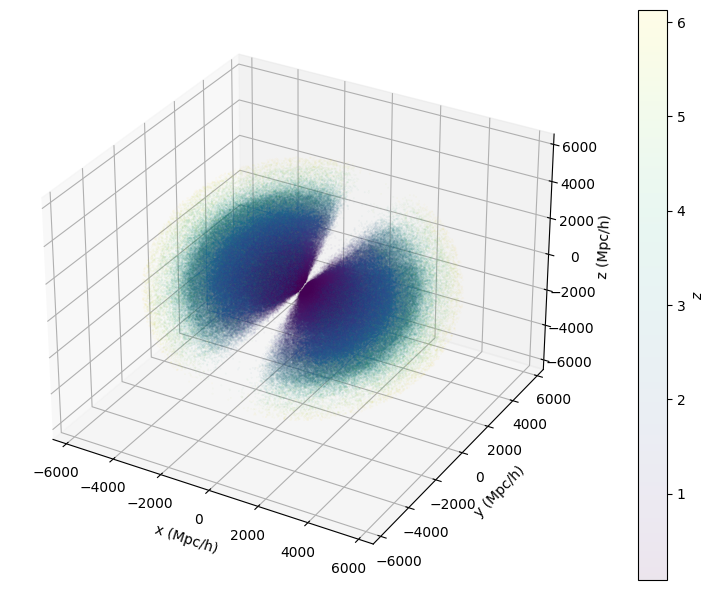

In [17]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(projection='3d')

im = ax.scatter(x, y, z, alpha=0.1, s=0.03, c=data_gaia['redshift_qsoc'])

ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)')
fig.colorbar(im, label='$z$')
fig.tight_layout()

## random catalog

In [18]:
randcat_fn = os.path.join(scratch, 'quasars/catalogs/random_stardustm1064_G20.0_10x.fits')

In [19]:
data_rand = Table.read(randcat_fn, format='fits')
data_rand

ra,dec,ebv
deg,deg,
float64,float64,float32
151.56589357613242,23.568616572594635,0.038340338
354.49177786258855,-4.751117197754766,0.034039885
30.30987249484305,27.922297677390155,0.059455413
156.73332287306684,24.25396549659017,0.01602192
129.8439116336529,72.85156420048067,0.024157831
304.6346872420625,-27.311127370214493,0.0842194
269.4997977419355,16.24390909604068,0.11113772
169.49044605551342,-44.90037425482629,0.12425914


In [21]:
pos = ra_dec(data_rand)
pos.shape

(6489060, 2)

In [24]:
data_gaia['redshift_spz'].shape

(648842,)

In [25]:
rng = default_rng(seed=123)
zs_rand = generate_random_z(pos[:,0], pos[:,1], data_gaia['redshift_spz'], rng)

### lay out code

In [30]:
import os
import time
import datetime
import numpy as np
from numpy.random import default_rng
from astropy.table import Table
# from astropy.io import fits
# import astropy.cosmology
# from astropy import units as u
# from astropy.coordinates import SkyCoord

from funcs.load_tools import ra_dec
from funcs.convert_data_to_xyz import convert_radecz_to_xyz
from funcs.random_cat import generate_random_z
import globals
globals.initialize_vals()

In [31]:
# parameters
rmin = globals.rmin
rmax = globals.rmax
nbins = globals.nbins
ncont = globals.ncont
nthreads = globals.nthreads

In [32]:
# DATA CATALOG
print("getting data catalog...")
cat_dir = os.path.join('/scratch/aew492/quasars/catalogs')
quasar_fn = os.path.join(cat_dir, 'gaia_G20.0.fits')
datatable = Table.read(quasar_fn, format='fits')
# (RA, Dec) and redshifts z
ra, dec = ra_dec(datatable).T
redshifts = datatable['redshift_spz']
# convert (RA, Dec, z) --> (x, y, z)
data_pos = convert_radecz_to_xyz(ra, dec, redshifts)
x, y, z = data_pos.T

getting data catalog...


In [33]:
# RANDOM CATALOG
print("getting random catalog...")
random_fn = os.path.join(cat_dir, 'random_stardustm1064_G20.0_10x.fits')
randtable = Table.read(random_fn, format='fits')
# (RA, Dec)
ra_rand, dec_rand = ra_dec(randtable).T
# shuffle data redshifts to random positions
print("shuffling redshifts...")
rng = default_rng(seed=123)
redshifts_rand = generate_random_z(ra_rand, dec_rand, redshifts, rng)
# convert (RA, Dec, z) --> (x, y, z)
rand_pos = convert_radecz_to_xyz(ra_rand, dec_rand, redshifts_rand)
xr, yr, zr = rand_pos.T

getting random catalog...
shuffling redshifts...
